100%|██████████| 2.29G/2.29G [00:09<00:00, 257MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2
Contents of base_dir: ['test', 'train', 'val', 'chest_xray', '__MACOSX']
Contents of train_dir: ['PNEUMONIA', 'NORMAL']
Contents of val_dir: ['PNEUMONIA', 'NORMAL']
Contents of test_dir: ['PNEUMONIA', 'NORMAL']
Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Epoch 1/10
163/163 [==============================] - 68s 413ms/step - loss: 0.5029 - accuracy: 0.7604 - val_loss: 0.9526 - val_accuracy: 0.5625
Epoch 2/10
163/163 [==============================] - 68s 416ms/step - loss: 0.3650 - accuracy: 0.8202 - val_loss: 0.4809 - val_accuracy: 0.8125
Epoch 3/10
163/163 [==============================] - 69s 422ms/step - loss: 0.3170 - accuracy: 0.8643 - val_loss: 1.0434 - val_accuracy: 0.6250
Epoch 4/10
163/163 [==============================] - 69s 421ms/step - loss: 0.2854 - accuracy: 0.8758 - val_loss: 0.5250 - va

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


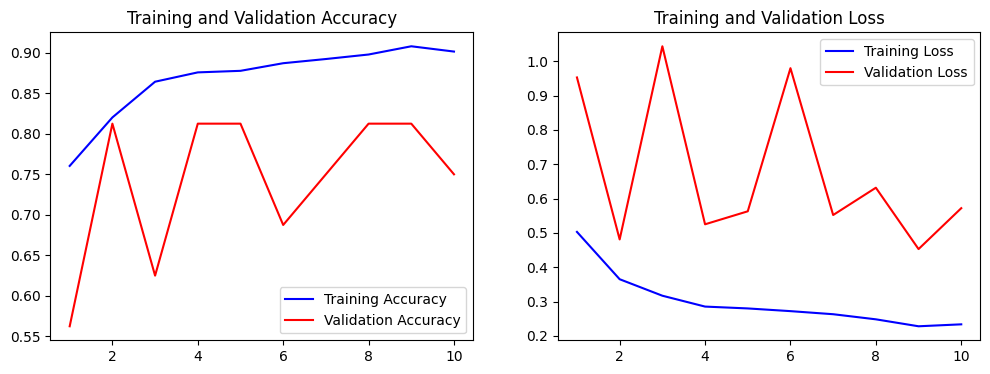

In [ ]:
import os
import kagglehub
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Fetching pneumonia x-ray images from Kaggle using their API
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")
print("Path to dataset files:", path)

# Configuring directory paths for different data splits
base_dir = os.path.join(path, 'chest_xray')  # Main folder containing all x-ray images
train_dir = os.path.join(base_dir, 'train')  # Training images location
val_dir = os.path.join(base_dir, 'val')      # Validation images location
test_dir = os.path.join(base_dir, 'test')    # Test images location

# Checking if directories contain expected files
print("Contents of base_dir:", os.listdir(base_dir))
print("Contents of train_dir:", os.listdir(train_dir))
print("Contents of val_dir:", os.listdir(val_dir))
print("Contents of test_dir:", os.listdir(test_dir))

# Preparing image augmentation for training data
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,            # Normalize pixel values
    rotation_range=20,            # Random rotations
    width_shift_range=0.2,        # Horizontal shifting
    height_shift_range=0.2,       # Vertical shifting
    shear_range=0.2,              # Shearing transformations
    zoom_range=0.2,               # Random zooming
    horizontal_flip=True,         # Flipping images horizontally
)

# Simple rescaling for validation and test data
val_datagen = ImageDataGenerator(rescale=1.0 / 255)
test_datagen = ImageDataGenerator(rescale=1.0 / 255)

# Creating data generators for each dataset split
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),  # Resizing all images to 150x150
    batch_size=32,           # Number of images processed together
    class_mode='binary',     # Binary classification task
)

val_data = val_datagen.flow_from_directory(
    val_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
)

test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
)

# Designing the neural network architecture
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),  # First convolutional layer
    MaxPooling2D((2, 2)),                                              # Pooling to reduce dimensions
    Conv2D(64, (3, 3), activation='relu'),                             # Second convolutional layer
    MaxPooling2D((2, 2)),                                              # More pooling
    Conv2D(128, (3, 3), activation='relu'),                            # Third convolutional layer
    MaxPooling2D((2, 2)),                                              # Final pooling
    Flatten(),                                                         # Flattening for dense layers
    Dense(128, activation='relu'),                                     # Fully connected layer
    Dropout(0.5),                                                      # Regularization
    Dense(1, activation='sigmoid'),                                    # Output layer for binary prediction
])

# Configuring model training parameters
model.compile(
    optimizer=Adam(learning_rate=0.001),  # Using Adam optimizer
    loss='binary_crossentropy',           # Appropriate loss function
    metrics=['accuracy'],                 # Tracking accuracy metric
)

# Training the model on our data
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=10,                          # Number of training cycles
    steps_per_epoch=len(train_data),    # Batches per epoch
    validation_steps=len(val_data),     # Validation batches
)

# Assessing model performance on unseen test data
test_loss, test_acc = model.evaluate(test_data)
print(f"Test Accuracy: {test_acc:.2f}")

# Storing the trained model for future use
model.save('pneumonia_detector.h5')
print("Model saved as 'pneumonia_detector.h5'.")

# Visualizing model training progress
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

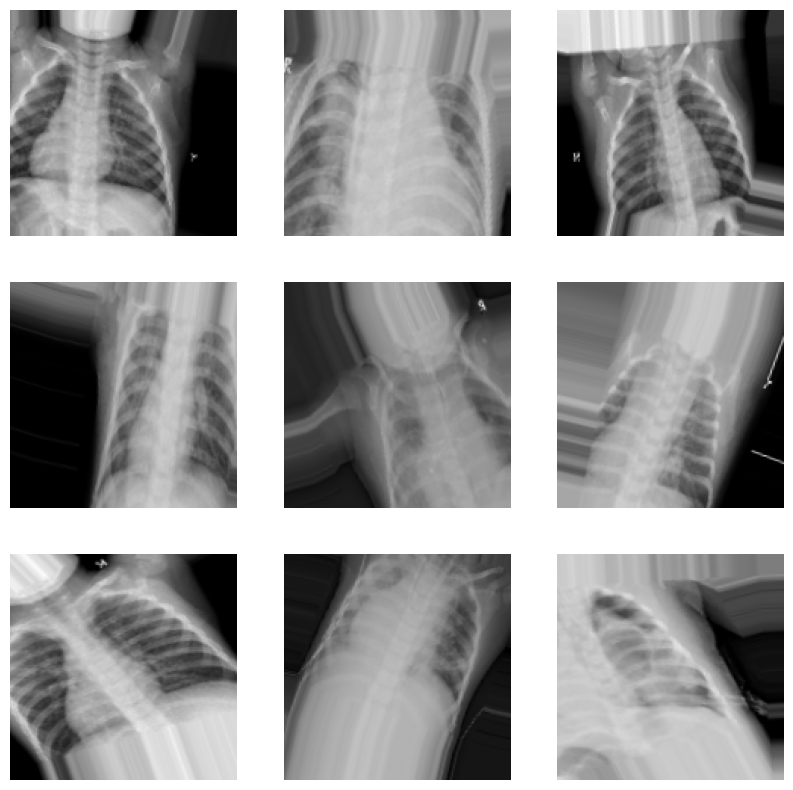

In [ ]:
# Visualizing augmented training samples to verify data preprocessing
plt.figure(figsize=(10, 10))  # Create a 10x10 inch figure for better visibility

# Get the first batch of images from our training generator
for images, _ in train_data:
    # Display a 3x3 grid of sample images
    for i in range(9):  
        # Apply random transformations to create augmented versions
        augmented_images = train_datagen.random_transform(images[i])  
        # Create subplots for each image
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images)
        plt.axis("off")  # Remove axis labels for cleaner display
    break  # Exit after processing the first batch to avoid multiple displays

plt.show()  # Render the visualization

58889256/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                              

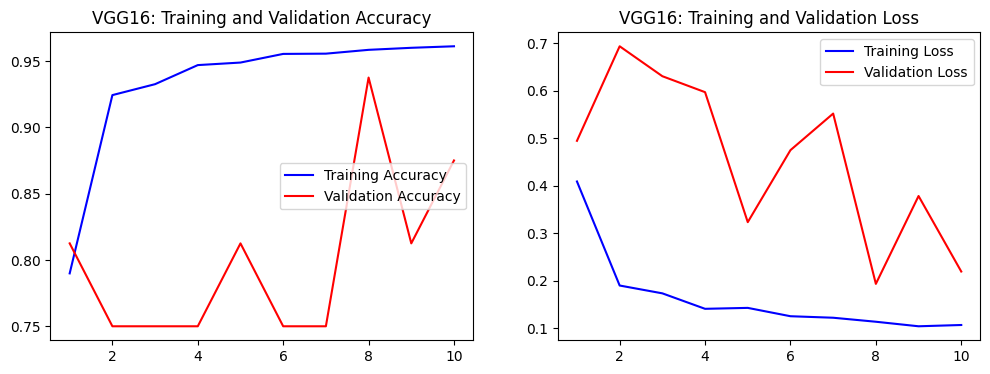

In [ ]:
# Implementing transfer learning with VGG16 architecture
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D

# Initialize VGG16 base model (pretrained on ImageNet)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Lock all base model layers initially to preserve learned features
for layer in base_model.layers:
    layer.trainable = False

# Construct new classification head for our specific task
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Convert feature maps to 1D vector
x = Dense(128, activation='relu')(x)  # Additional fully-connected layer
x = Dropout(0.5)(x)  # Regularization to prevent overfitting
x = Dense(1, activation='sigmoid')(x)  # Final binary classification layer

# Combine base model with new head
model_vgg16 = Model(inputs=base_model.input, outputs=x)

# Configure model training parameters
model_vgg16.compile(
    optimizer=Adam(learning_rate=0.0001),  # Conservative learning rate
    loss='binary_crossentropy',  # Suitable for binary classification
    metrics=['accuracy'],  # Track classification accuracy
)

# Display model architecture summary
model_vgg16.summary()

# Begin fine-tuning process
# Unlock last 4 convolutional blocks for targeted adjustment
for layer in base_model.layers[-4:]:
    layer.trainable = True

# Reconfigure model with finer learning rate for delicate tuning
model_vgg16.compile(
    optimizer=Adam(learning_rate=0.00001),  # Very small learning rate
    loss='binary_crossentropy',
    metrics=['accuracy'],
)

# Execute model training with fine-tuning
history_vgg16 = model_vgg16.fit(
    train_data,
    validation_data=val_data,
    epochs=10,
    steps_per_epoch=len(train_data),  # Process all training batches
    validation_steps=len(val_data),  # Process all validation batches
)

# Assess model performance on unseen test data
test_loss_vgg16, test_acc_vgg16 = model_vgg16.evaluate(test_data)
print(f"VGG16 Test Accuracy: {test_acc_vgg16:.2f}")

# Persist the fine-tuned model for deployment
model_vgg16.save('vgg16_pneumonia_detector.h5')
print("VGG16 Model saved as 'vgg16_pneumonia_detector.h5'.")

# Visualize training progress metrics
acc_vgg16 = history_vgg16.history['accuracy']
val_acc_vgg16 = history_vgg16.history['val_accuracy']
loss_vgg16 = history_vgg16.history['loss']
val_loss_vgg16 = history_vgg16.history['val_loss']

epochs_vgg16 = range(1, len(acc_vgg16) + 1)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_vgg16, acc_vgg16, 'b', label='Training Accuracy')
plt.plot(epochs_vgg16, val_acc_vgg16, 'r', label='Validation Accuracy')
plt.title('VGG16: Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_vgg16, loss_vgg16, 'b', label='Training Loss')
plt.plot(epochs_vgg16, val_loss_vgg16, 'r', label='Validation Loss')
plt.title('VGG16: Training and Validation Loss')
plt.legend()

plt.show()